## Text Message Classification

Classes taken (class_id) - 
1. personal
2. promotional
3. Temporary/ OTP
4. bank 
5. Promotions from service provider (like Vodafone)
6. miscellanous (orders, temporary OTP*)

Goal - Given a new text message, we want to assign it into one of these 6 categories. (We've assumed that the incoming message would fall into any of these 6 categories). We've already cleaned the data in the excel file. (We've not used a .csv file because of the fact that 'utf-8' codec cannot be decode byte 0x89 in a csv file)

Reference - https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [3]:
import pandas as pd
df = pd.read_excel('lean1.xlsx')
df.head()

,message,class_id,class
0,+91 86306 28242 Ankit saini,1,Personal
1,"Sunn, sohini. 2 min ke lie free hai? ??",1,Personal
2,"Sun, Aaj ticket book karni hai. Aur post karna...",1,Personal
3,"28, 29, 30 September.\nAgar loaded scene hai, ...",1,Personal
4,3 moderator\n5 investor\nNaam bhej aur call ka...,1,Personal


Going through the dataset, we see that the classes are unevenly distributed. So, we represent this distribution using matplotlib.

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('class').message.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

Most of the classifiers and learning algorithms expect numerical feature vectors with a fixed size rather than raw text documents with variable length (as they cannot directly process the text). Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

Specifically, for each term in our dataset, we calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. For each document, the message in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer #using TfidfVectorizer to convert message into TF-IDF weighted vectors
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.message).toarray()
labels = df.class_id
features.shape

(2113, 1256)

Now, each of 2113 consumer complaint narratives is represented by 1256 features, representing the tf-idf score for different unigrams and bigrams.

To train supervised classifiers, we first We explored vector representations such as TF-IDF weighted vectors.
Now, after transforming the “message” into a vector of numbers, we can now train supervised classifiers to train the unseen “message” and predict the “class” on which they fall.

In [6]:
#Multinomial Naive Bayes Classifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['class'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [7]:
#Making predictions from untrained data
print(clf.predict(count_vect.transform(["The Best Value 2G/3G/4G Data Packs for U! Rs 16=1GB/ 1 day Rs 28=500mb/ 28 days Rs.49=1GB/28 Days Offers valid for limited period. Recharge today. Vodafone"])))

['Promo SP']


In [8]:
#Making predictions from untrained data
print(clf.predict(count_vect.transform(["Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!"])))

['Personal']


We will now test different machine learning models, evaluating their accuracies to identify the best model. 4 Models used - Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine, Random Forest.

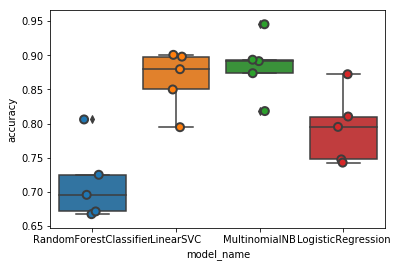

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns #To visualize the accuracy of different models
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.864668
LogisticRegression        0.793714
MultinomialNB             0.884566
RandomForestClassifier    0.713180
Name: accuracy, dtype: float64

Continuing with the best model, computing the confusion matrix to see the discrepancies between predicted and actual labels.

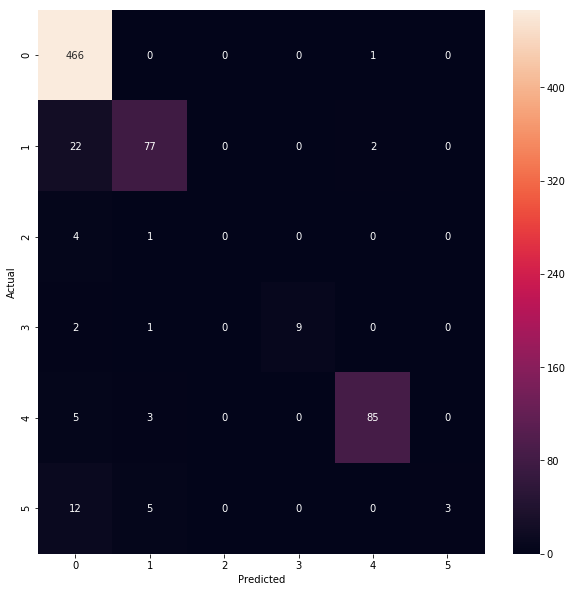

In [14]:
model = MultinomialNB() #as MultinomailNB has the highest mean accuracy.
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. 

In [15]:
#Classification report for each class.
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['class'].unique()))

             precision    recall  f1-score   support

   Personal       0.91      1.00      0.95       467
      Promo       0.89      0.76      0.82       101
   Temp/OTP       0.00      0.00      0.00         5
       Bank       1.00      0.75      0.86        12
   Promo SP       0.97      0.91      0.94        93
       Misc       1.00      0.15      0.26        20

avg / total       0.91      0.92      0.90       698



c:\users\yashpc\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
